In [27]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# custom libraries
import network as network

## we'll first confirm that our code works as predicted

In [3]:
# set seed for reproducibility
np.random.seed(0)
# create a neural network
nn = network.NeuronNetwork(n_inputs=4, n_outputs=2, hidden_layers=[2, 1])

# create input and output data
X = np.array([[1, 1, 2, 3], [1, 0, 2, 3], [0, 1, 2, 3], [0, 0, 2, 3]])
y = np.array([[1, 0], [0.5, 0.5], [0.5, 0.5], [0, 1]])
nn.predict(X)

array([[0.52042064, 0.69532453],
       [0.52061257, 0.69696681],
       [0.5193379 , 0.68596812],
       [0.52004856, 0.69212675]])

In [4]:
# add another node
nid = nn.add_node()
# we want to connect this node to the first hidden layer and to the outputs
nn.add_weight(0, 5)
nn.add_weight(1, 5)
nn.add_weight(5, 3)
nn.add_weight(5, 4)

model did not converge


array([[0.80473085, 0.17905748],
       [0.51016062, 0.48989045],
       [0.49124814, 0.51027216],
       [0.17240211, 0.84472691]])

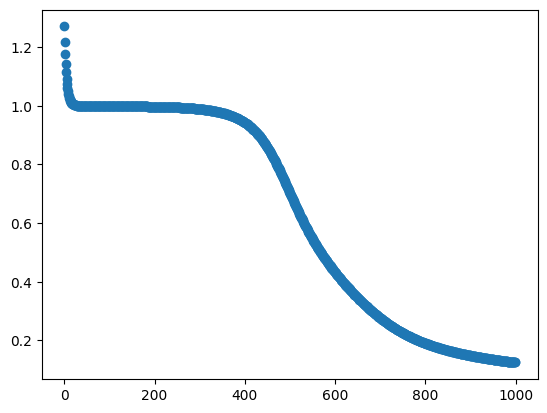

In [5]:
# perform training
losses, params = nn.train(X, y, epochs=1000, initial_learning_rate=1, tolerance=1e-6, save_params=True)
plt.scatter(range(len(losses)), losses)
nn.predict(X)

<AxesSubplot:>

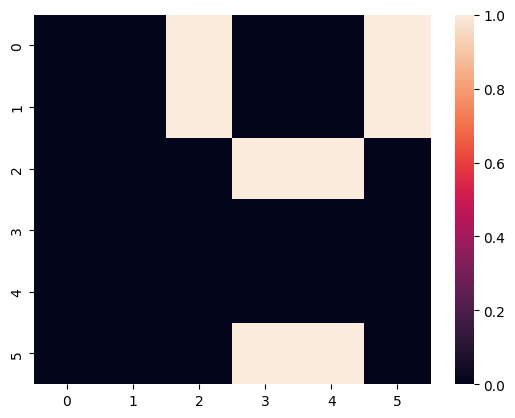

In [6]:
# this heatmap will mark a 1 (off-white) is the row feeds into the column
sns.heatmap(nn.adj)

## then we'll gather the relevant data from the curated pairs

In [10]:
# load in the VDJdb data
df = pd.read_table('/ssd1/dchen/GNN_PEPTIDE_TCR/data/vdjdb_confidence2_trb_hlaa0201_humanonly.tsv', index_col=0)
df = df.reset_index().iloc[:, 1:]
assert sum(df['Epitope'] == 'NLVPMVATV') == sum(df['Epitope gene'] == 'pp65')

assert df['CDR3'].apply(lambda x: x.count(' ')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('_')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('-')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('#')).max() == 0

df['CDR3'], df['Epitope'] = df['CDR3'].str.upper(), df['Epitope'].str.upper()
df = df.loc[~df['CDR3'].apply(lambda x: 'X' in x)]
df = df.loc[~df['Epitope'].apply(lambda x: 'X' in x)]

df_vdjdb = df[['CDR3','Epitope']].copy()

In [11]:
# load in the IEDB data
df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/iedb.receptor_table_export_1692393367.csv', index_col=0)
df = df.reset_index().iloc[:, 1:]

# filter only for the beta sequences
df = df.loc[df['Chain 2 - Type'] == 'beta']
df = df.dropna(subset=['Chain 2 - CDR3 Curated'])
df = df[['Chain 2 - CDR3 Curated', 'Epitope - Name']]
df.columns = ['CDR3','Epitope']

assert df['CDR3'].apply(lambda x: x.count(' ')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('_')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('-')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('#')).max() == 0

df['CDR3'], df['Epitope'] = df['CDR3'].str.upper(), df['Epitope'].str.upper()
df = df.loc[~df['CDR3'].apply(lambda x: 'X' in x)]
df = df.loc[~df['Epitope'].apply(lambda x: 'X' in x)]

df_iedb = df.copy()

/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (2,10,11,12,13,14,15,16,18,19,20,21,22,23,28,29,34,35,42,43,44,45,46,47,48,49,50,57,58,63,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
# load in the McPAS data
df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/McPAS-TCR.csv', encoding='windows-1252')
mask = (df['Species'] == 'Human') & (df['MHC'].isin(['HLA-A*02:01','HLA-A*2:01','HLA-A*2:01,*6:801']))
df = df.loc[mask, ['CDR3.beta.aa','Epitope.peptide']].dropna()
df.columns = ['CDR3','Epitope']

assert df['CDR3'].apply(lambda x: x.count(' ')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('_')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('-')).max() == 0
assert df['CDR3'].apply(lambda x: x.count('#')).max() == 0

df['CDR3'], df['Epitope'] = df['CDR3'].str.upper(), df['Epitope'].str.upper()
df = df.loc[~df['CDR3'].apply(lambda x: 'X' in x)]
df = df.loc[~df['Epitope'].apply(lambda x: 'X' in x)]

df_mcpas = df.copy()

/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (13,17,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
# combine all of the datasets
df = pd.concat([df_vdjdb, df_iedb, df_mcpas], axis=0)
# remove any erroneous epitopes
df = df.loc[df['Epitope'].apply(lambda x: x.count(' ')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('_')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('-')) == 0]
df = df.loc[df['Epitope'].apply(lambda x: x.count('#')) == 0]

[Text(0.5, 0, 'Length'), Text(0, 0.5, 'N-CDR3s')]

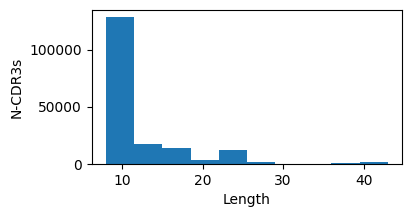

In [14]:
# examine lengths of peptides
fig, ax = plt.subplots(figsize=[4, 2])
ax.grid(False)
ax.hist(df['Epitope'].apply(len), bins=10)
ax.set(xlabel='Length', ylabel='N-CDR3s')

In [15]:
# accepted range of epitopes falls between 8-11
df = df.loc[(df['Epitope'].apply(len) <= 11) & (df['Epitope'].apply(len) >= 8)]

[Text(0.5, 0, 'Length'), Text(0, 0.5, 'N-Peptides')]

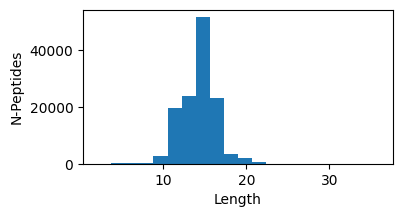

In [16]:
# examine lengths of cdr3s
fig, ax = plt.subplots(figsize=[4, 2])
ax.grid(False)
ax.hist(df['CDR3'].apply(len), bins=20)
ax.set(xlabel='Length', ylabel='N-Peptides')

In [17]:
# accepted range of cdr3s falls between 10-22
df = df.loc[(df['CDR3'].apply(len) <= 22) & (df['CDR3'].apply(len) >= 10)]
df = df.reset_index().iloc[:, 1:]

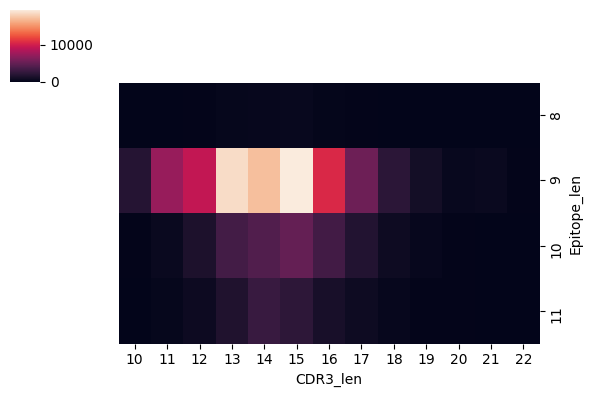

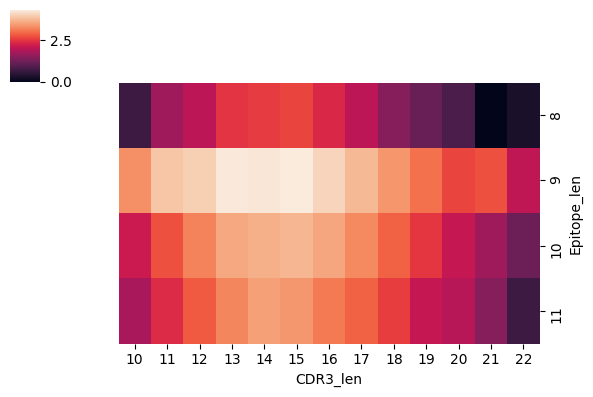

In [18]:
# examine lengths
df['CDR3_len'], df['Epitope_len'] = df['CDR3'].apply(len), df['Epitope'].apply(len)

plot = df[['CDR3_len','Epitope_len']].value_counts().reset_index()
plot = plot.pivot_table(index='Epitope_len', columns='CDR3_len', values=0, aggfunc=np.sum)

g = sns.clustermap(plot.astype(float).fillna(0), figsize=[6, 4],
                   row_cluster=False, col_cluster=False)
g = sns.clustermap(np.log10(plot.astype(float).fillna(0)+1), figsize=[6, 4],
                   row_cluster=False, col_cluster=False)

## then we'll establish negative controls

In [25]:
# now we need to mix and match to ensure we get good representation of negative samples as well
df = df[['CDR3','Epitope']]
counts = df['Epitope'].value_counts()
counts.iloc[:5]

YVLDHLIVV      16707
KLGGALQAK      14323
GLCTLVAML      11191
GILGFVFTL      10445
HTTDPSFLGRY     5814
Name: Epitope, dtype: int64

In [26]:
from Levenshtein import distance
from tqdm import tqdm
# our goal here is to find the similar and different peptides in our dataset
df_l = pd.DataFrame(index=counts.index, columns=counts.index)
for idx, pep1 in tqdm(enumerate(counts.index[:-1]), total=df_l.shape[0]):
    df_l.loc[pep1, pep1] = 0
    for pep2 in counts.index[idx+1:]:
        d = distance(pep1, pep2)
        df_l.loc[pep1, pep2] = d
        df_l.loc[pep2, pep1] = d
df_l.loc[pep2, pep2] = 0

# write down this table
df_l.to_csv('../outputs/model_v3/full.epitope.levenshtein.csv')

100%|██████████████████████████████████████▉| 1575/1576 [02:40<00:00,  9.82it/s]


In [28]:
# change projection quality
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

# gather linkage and fcluster
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
# get initial mapping
Z = linkage(df_l.astype(float), method='ward')
max_score, max_t = 0, 0
for t in tqdm(range(5, 31)):
    # get clusters
    clusters = fcluster(Z, criterion='maxclust', t=t)
    clusters = pd.Series(clusters, index=df_l.index)
    score = silhouette_score(df_l, clusters)
    # compare with previous
    if score >= max_score:
        max_t = t
        max_score = score
print(max_t, max_score)
clusters = fcluster(Z, criterion='maxclust', t=max_t)
clusters = pd.Series(clusters, index=df_l.index)

/tmp/ipykernel_24814/555829679.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(df_l.astype(float), method='ward')
100%|███████████████████████████████████████████| 26/26 [00:04<00:00,  5.46it/s]

7 0.060271632770893376


In [29]:
# map out colors
colors = sns.color_palette('hls', max_t).as_hex()
palette = {idx+1:colors[idx] for idx in range(max_t)}
colors = clusters.map(palette)

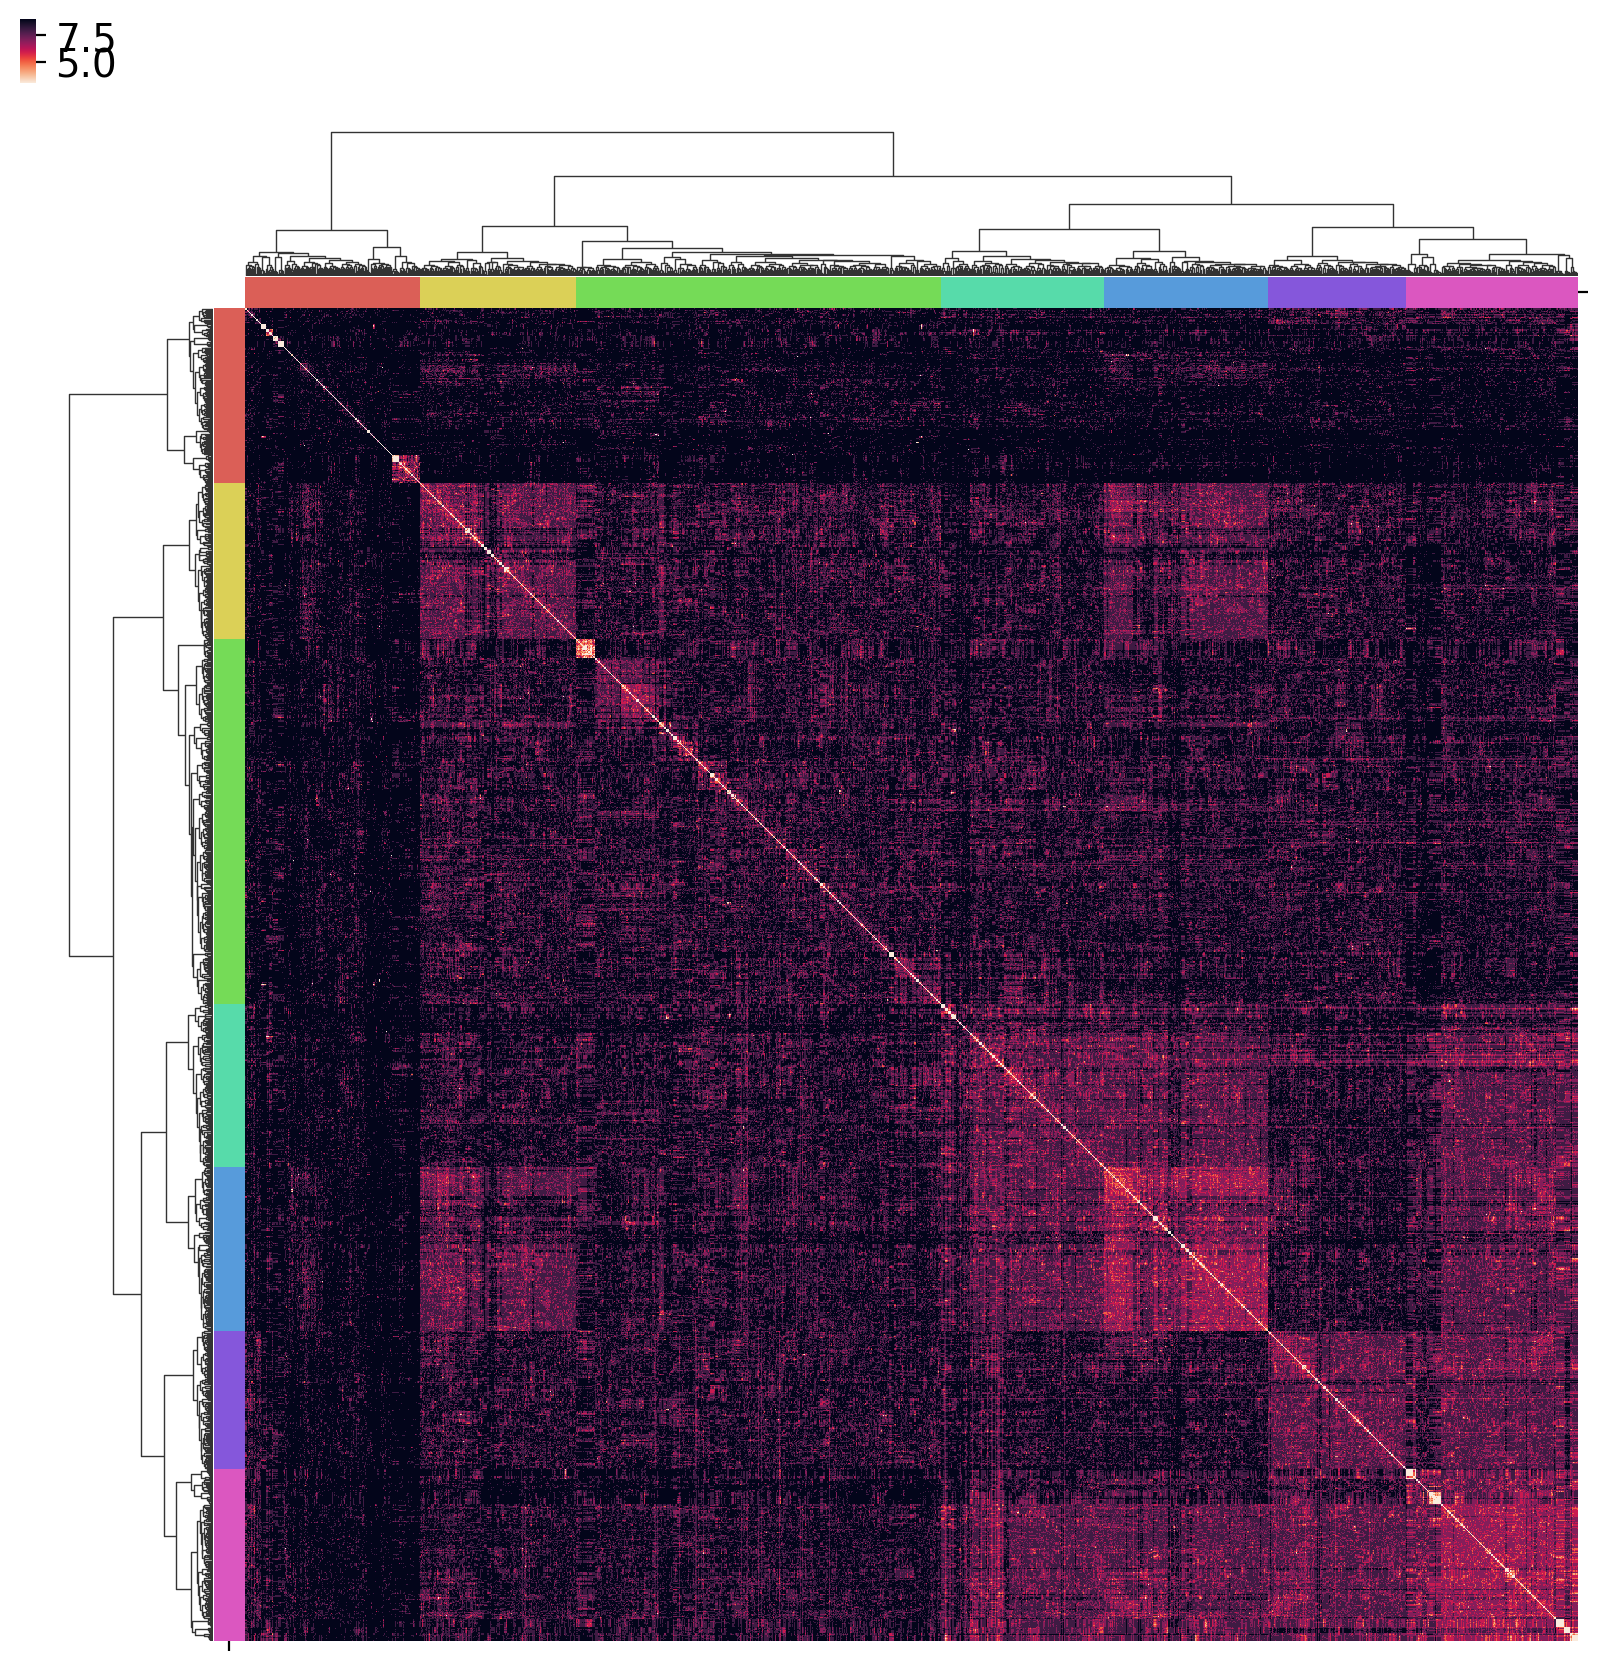

In [30]:
# plot levenshtein
sns.clustermap(df_l.astype(float), figsize=[8, 8], method='ward', xticklabels=0, yticklabels=0,
               dendrogram_ratio=.1, cbar_pos=(0, 1, .01, .04), vmin=3, vmax=9, cmap='rocket_r',
               row_colors=colors, col_colors=colors, colors_ratio=.02, row_linkage=Z, col_linkage=Z)

In [31]:
# write the clustering
clusters.to_csv('../outputs/model_v3/full.epitope.levenshtein.clusters.csv')

# write the original input
df.to_csv('../outputs/model_v3/full.input.X.csv')

In [32]:
# now the reason we do this is because similar peptides are likely to bind to similar CDR3s
# we must exclude these peptides when we are selecting our negative controls
# in fact we want the most different peptides we can possibly get

In [33]:
# set seed and identify irrelevant matches
np.random.seed(0)
irrs = []

for pep in tqdm(df_l.index):
    # gather peptide cdr3 information
    n_cdr3s = counts.loc[pep]
    pep_cdr3s = df.loc[df['Epitope'] == pep, 'CDR3'].unique()
    # we first grab the peptide levenshtein distances
    pep_levenshtein = df_l[pep].sort_values()[::-1]
    # systematically identify negative controls
    irr_cdr3s = []
    while n_cdr3s > 0:
        # then we look at the max distance, gather those peptides, randomly choose one
        # find associated CDR3s that don't overlap with the current peptide
        vmax = pep_levenshtein.max()
        irr_peps = pep_levenshtein.index[pep_levenshtein == vmax]
        # reset for the next round if needed
        pep_levenshtein = pep_levenshtein[pep_levenshtein < vmax]
        # find the irrelevant peptide CDR3s and make sure they don't overlap
        mask = (df['Epitope'].isin(irr_peps)) & (~df['CDR3'].isin(pep_cdr3s))
        if sum(mask) == 0:
            continue
        # if we have cdr3s then grab them out
        cdr3s = df.loc[mask, 'CDR3']
        # if there are more than we need randomly select
        if len(cdr3s) > n_cdr3s:
            irr_cdr3s = np.random.choice(cdr3s, size=n_cdr3s, replace=False).tolist()
            break
        # otherwise keep moving
        else:
            irr_cdr3s.extend(cdr3s.tolist())
            n_cdr3s -= len(cdr3s)
    # compile the full list
    irr = pd.DataFrame(irr_cdr3s, columns=['CDR3'])
    irr['Epitope'] = pep
    irrs.append(irr)

100%|███████████████████████████████████████| 1576/1576 [00:45<00:00, 34.65it/s]


In [34]:
# gather irrelevant pairs
irr = pd.concat(irrs, axis=0)
# write the control input
irr.to_csv('../outputs/model_v3/full.control.X.csv')

## then we'll prepare inputs for the modeling

In [3]:
from constants import *

# the first step is to create a conversion map for CDR3 sequences
alphabet = sorted(set([el for x in df['CDR3'].unique() for el in list(x)]))
# work through an example
columns = alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
X_cdr3s = pd.DataFrame(index=df['CDR3'].unique(), columns=[f'{idx}{col}' for idx in range(100) for col in columns])
for peptide in tqdm(X_cdr3s.index):
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_cdr3s.loc[peptide] = X.values.flatten()

In [ ]:
# then to repeat this step for paired epitopes
alphabet = sorted(set([el for x in df['Epitope'].unique() for el in list(x)]))
# work through an example
columns = alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
X_epitopes = pd.DataFrame(index=df['Epitope'].unique(), columns=[f'{idx}{col}' for idx in range(100) for col in columns])
for peptide in tqdm(X_epitopes.index):
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(100), columns=columns)
    step = 100 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = 100
        # map to the coordinates, weight is scaled by 0.01 to reduce to single digit values, same with hydrop with 0.5
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / 100
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    X_epitopes.loc[peptide] = X.values.flatten()

In [ ]:
# we'll write both of these values
X_cdr3s.to_csv('../outputs/model_v3/cdr3.conversion.csv')
X_epitopes.to_csv('../outputs/model_v3/epitope.conversion.csv')

In [99]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.csv', index_col=0)
df = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)

In [96]:
# grab a certain subset
np.random.seed(0)
n_rows = 1000
perc_test = 0.80
# > subset target
idxs = np.random.choice(df.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_test)], idxs[round(n_rows * perc_test):]
print(len(idxs), len(idys))
df, df_test = df.loc[idxs], df.loc[idys]
# > subset control
idxs = np.random.choice(irr.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_test)], idxs[round(n_rows * perc_test):]
print(len(idxs), len(idys))
irr, irr_test = irr.loc[idxs], irr.loc[idys]

800 200
800 200


In [100]:
# create X
X_train = df.append(irr).reset_index().iloc[:, 1:]
X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
# combine
X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
X_train = X_train_cdr3s.join(X_epitopes)

# grab y
y_train = pd.Series(np.ones(df.shape[0])).append(pd.Series(np.zeros(irr.shape[0]))).astype(int)
y_train = y_train.reset_index().iloc[:, 1:][0]

In [101]:
# create X for testing
X_test = df_test.append(irr_test).reset_index().iloc[:, 1:]
X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
# combine
X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
X_test = X_test_cdr3s.join(X_test_epitopes)

# grab y for testing
y_test = pd.Series(np.ones(df_test.shape[0])).append(pd.Series(np.zeros(irr_test.shape[0]))).astype(int)
y_test = y_test.reset_index().iloc[:, 1:][0]

In [104]:
# remove any columns that are constant or all zero
X_train = X_train.loc[:, X_train.abs().sum(0) > 0]
X_train = X_train.loc[:, X_train.nunique(0) > 1]
# now display the number of arguments post filtering
X_train.shape[1]

2494

In [105]:
# normalize
means = X_train.mean()
X_train -= X_train.mean()
stds = X_train.std()
X_train /= X_train.std()
# normalize test
X_test = X_test[X_train.columns]
X_test -= means
X_test /= stds
# write normalization factors
means.to_csv('../outputs/model_v3/model_v3.means.csv')
stds.to_csv('../outputs/model_v3/model_v3.stds.csv')

In [115]:
from sklearn.neural_network import MLPClassifier
# set seed for reproducibility
np.random.seed(0)
# create a neural network
nn = MLPClassifier(hidden_layer_sizes=[100], random_state=0, activation='relu', solver='adam',
                   tol=1e-4, validation_fraction=0.25, max_iter=200, shuffle=True, learning_rate='adaptive')
nn = nn.fit(X_train, y_train)

/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [116]:
# look at prediction for training
pred = nn.predict(X_train)
# look at current auc and acc
auc_value = roc_auc_score(pred, y_train.values)
acc_value = accuracy_score(pred, y_train.values)
print(auc_value, acc_value)

# look at prediction for testing
pred = nn.predict(X_test)
# look at current auc and acc
auc_value = roc_auc_score(pred, y_test.values)
acc_value = accuracy_score(pred, y_test.values)
print(auc_value, acc_value)

0.7796214980771968 0.7864381554775248
0.5381544373014113 0.8830430358532352


In [ ]:
# write model and datasets
from joblib import dump
dump(nn, '../outputs/model_v3/model_v3.pkl')
X_train.to_csv('../outputs/model_v3/full.train.X.csv')
X_test.to_csv('../outputs/model_v3/full.test.X.csv')
y_train.to_csv('../outputs/model_v3/full.train.y.csv')
y_test.to_csv('../outputs/model_v3/full.test.y.csv')